In [22]:
import os
import torch
from torch import nn
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [24]:
data_set = pd.read_csv("data.csv")
train_dataset = data_set.sample(frac=0.8, random_state=25)

testing_data = data_set.drop(train_dataset.index)
testing_data = testing_data.drop(columns=['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'])
testing_class_encoding = pd.get_dummies(testing_data.Class)
testing_data = testing_data.drop(columns=['Class'])

data_set = train_dataset
data_set = data_set.drop(columns=['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'])
class_encoding = pd.get_dummies(data_set.Class)

data_set = data_set.drop(columns=['Class'])


minmax = MinMaxScaler()
data_set = minmax.fit_transform(data_set)
testing_data = minmax.fit_transform(testing_data)

testing_class_encoding = testing_class_encoding.to_numpy(dtype="float")
testing_data_set = []
for i in range(len(testing_data)):
    testing_data_set.append([testing_data[i],testing_class_encoding[i]])


class_encoding = class_encoding.to_numpy(dtype="float")
training_data_set = []
for i in range(len(data_set)):
    training_data_set.append([data_set[i],class_encoding[i]])



trainloader = torch.utils.data.DataLoader(training_data_set, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testing_data_set, batch_size=32, shuffle=True)
# for data in training_data_set:
# 	print (data)
print(training_data_set[0])

[array([0.6544029 , 0.06580018, 0.98435621, 0.94595728, 0.55510717,
       0.44178502, 0.66575363, 0.28770379, 0.00199377, 0.01373862,
       0.23747495]), array([0., 1., 0.])]


In [25]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.optim = None
        self.lossFct = nn.CrossEntropyLoss()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(11, 28),
            nn.ReLU(),
            nn.Linear(28, 28),
            nn.ReLU(),
            nn.Linear(28, 3),
        )

    def forward(self, x):

        logits = self.linear_relu_stack(x)
        return nn.Softmax(dim=0)(logits)

    def train(self, data_loader=trainloader, epochs=30, validation_data=None):
        train_accuracy_results = []
        test_accuracy_results = []
        for epoch in range(epochs):
            running_loss = self._train_iteration(data_loader)
            val_loss = None
            if validation_data is not None:
                y_hat = self(validation_data['X'])
                val_loss = self.lossFct(input=y_hat, target=validation_data['y']).detach().numpy()
                print('[%d] loss: %.3f | validation loss: %.5f' %
                  (epoch + 1, running_loss, val_loss))
            else:
                print('[%d] loss: %.3f' %
                  (epoch + 1, running_loss))

            train_accuracy_results.append(predict(self, dataloader=trainloader))
            test_accuracy_results.append(predict(self))

        fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
        fig.suptitle('Training Metrics')

        axes[0].set_ylabel("Training", fontsize=14)
        axes[0].plot(train_accuracy_results)

        axes[1].set_ylabel("Validation", fontsize=14)
        axes[1].set_xlabel("Epoch", fontsize=14)
        axes[1].plot(test_accuracy_results)
        plt.show()


    def _train_iteration(self,data_loader):
        running_loss = 0.0
        for i, data in enumerate(data_loader):

            inputs, labels = data

            inputs = inputs.float()
            labels = labels.float()




            ### Add the closure function to calculate the gradient.
            def closure():
                if torch.is_grad_enabled():
                    self.optim.zero_grad()
                output = self(inputs)
                loss = self.lossFct(output, labels)
                if loss.requires_grad:
                    loss.backward()
                return loss

            self.optim.step(closure)

            # calculate the loss again for monitoring
            output = self(inputs)
            loss = closure()
            running_loss += loss.item()

        return running_loss



In [26]:
def predict(nn_model, dataloader = testloader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = nn_model(inputs.float())
            # the class with the highest energy is what we choose as prediction

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            # for i, val in enumerate(predicted):
            #     if labels.data[i][predicted]==1:
            #         correct += 1
            one_hot_target = nn.functional.one_hot(predicted, num_classes=3)
            one_hot_target = one_hot_target.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            labels = labels.astype(int)
            # print(one_hot_target)

            num_cor = (one_hot_target == labels)
            for row in num_cor:
                if all(row):
                    correct += 1



    return 100 * correct / total


NeuralNetwork(
  (lossFct): CrossEntropyLoss()
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=11, out_features=28, bias=True)
    (1): ReLU()
    (2): Linear(in_features=28, out_features=28, bias=True)
    (3): ReLU()
    (4): Linear(in_features=28, out_features=3, bias=True)
  )
)


C:\Users\luqma\AppData\Local\Temp/ipykernel_23444/3253562424.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


[1] loss: 268.073 | validation loss: 1.09776
[2] loss: 268.260 | validation loss: 1.09776
[3] loss: 268.345 | validation loss: 1.09776
[4] loss: 267.994 | validation loss: 1.09776
[5] loss: 267.952 | validation loss: 1.09776
[6] loss: 268.090 | validation loss: 1.09776
[7] loss: 268.019 | validation loss: 1.09776
[8] loss: 267.951 | validation loss: 1.09776
[9] loss: 268.081 | validation loss: 1.09776
[10] loss: 268.112 | validation loss: 1.09776
[11] loss: 268.210 | validation loss: 1.09776
[12] loss: 267.978 | validation loss: 1.09776
[13] loss: 268.190 | validation loss: 1.09776
[14] loss: 268.152 | validation loss: 1.09776
[15] loss: 268.051 | validation loss: 1.09776
[16] loss: 268.232 | validation loss: 1.09776
[17] loss: 268.154 | validation loss: 1.09776
[18] loss: 267.948 | validation loss: 1.09776
[19] loss: 268.464 | validation loss: 1.09776
[20] loss: 267.968 | validation loss: 1.09776
[21] loss: 268.175 | validation loss: 1.09776
[22] loss: 268.046 | validation loss: 1.097

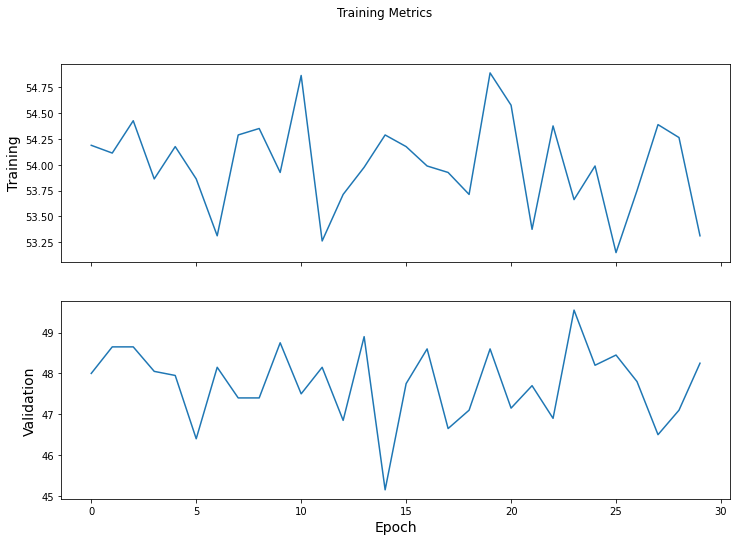

In [27]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

model = NeuralNetwork().to(device)
model.optim = torch.optim.LBFGS(model.parameters(), history_size=1, max_iter=1, lr=0.01, line_search_fn='strong_wolfe')
model.apply(init_weights)
print(model)
model.train(validation_data= {"X":torch.Tensor(testing_data), "y":torch.Tensor(testing_class_encoding)})
# model.train()
# model.train(validation_data= {"X":torch.Tensor(data_set), "y":torch.Tensor(class_encoding)})



In [28]:
predict(model)



46.9